# Sorting lists of length 50, without repetition

This experiment was based on the [suggestion given by Neel Nanda](https://www.lesswrong.com/s/yivyHaCAmMJ3CqSyj/p/ejtFsvyhRkMofKAFy#Problems).

## Variable hyperparameters

In [ ]:
# Fixed length of list to be sorted
LIST_LENGTH = 50

# Size of vocabulary
D_VOCAB = 66

# Should lists have repetitions?
ALLOW_REPETITIONS = False

# Attention only? (False -> model includes MLPs)
ATTN_ONLY = True

# Model dimenions
N_LAYERS = 1
N_HEADS = 1
D_MODEL = 128
D_HEAD = 32
D_MLP = None

if ATTN_ONLY:
    D_MLP = None

# Default batch size
DEFAULT_BATCH_SIZE = 32

# If you want to use pretrained weights, replace None by the path to the pkl file.
path_pkl_pretrained_weights = None

## Prelude

### Install and import

In [ ]:
try:
    import transformer_lens
except:
    !pip install git+https://github.com/neelnanda-io/TransformerLens
    !pip install circuitsvis

In [ ]:
from __future__ import annotations
from dataclasses import dataclass, field
from datetime import datetime as dt
from itertools import repeat
import os
import pickle
import random
from typing import cast, Generator, Literal

import circuitsvis as cv
from fancy_einsum import einsum
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn, tensor, Tensor, TensorType as TT
from torch.nn import functional as F
from transformer_lens import HookedTransformerConfig, HookedTransformer
from tqdm import tqdm
from typing_extensions import Self

cv.examples.hello("You")

### Invariable hyperparameters

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{DEVICE = }")

# Seeds to generate training, validation, and test data
TRAIN_SEED = 42
VAL_SEED = 66
TEST_SEED = 1729

# Context length: [start, *(unsorted_)list_length, mid, *(sorted_)list_length]
N_CTX = 2 * LIST_LENGTH + 2

# "Real" tokens range from 0 to D_VOCAB - 2 (non-inclusive)
VOCAB_MIN_ID = 0
VOCAB_MAX_ID = D_VOCAB - 2

# START token is D_VOCAB - 2 and MID token is D_VOCAB - 1
START_TOKEN_ID = VOCAB_MAX_ID
MID_TOKEN_ID = D_VOCAB - 1

DEVICE = 'cpu'


### Data generator and datasets

In [ ]:
def generate_list(batch_size: int) -> Tensor:
    if ALLOW_REPETITIONS:
        return torch.randint(VOCAB_MIN_ID, VOCAB_MAX_ID, (batch_size, LIST_LENGTH)).to(DEVICE)
    return tensor([
        random.sample(range(VOCAB_MIN_ID, VOCAB_MAX_ID), k=LIST_LENGTH) 
        for _ in range(batch_size)
    ]).to(DEVICE)

# General generator
def make_data_gen(
    *,
    batch_size: int = DEFAULT_BATCH_SIZE,
    dataset: Literal["train", "val", "test"], # probably this arg needs a better name,
) -> Generator[Tensor, None, None]:
    assert dataset in ("train", "val", "test")
    if dataset == "train":
        seed = TRAIN_SEED
    elif dataset == "val":
        seed = VAL_SEED
    else: # test
        seed = TEST_SEED
    torch.manual_seed(seed)
    while True:
        # Generate random numbers
        x = generate_list(batch_size)
        # Sort
        x_sorted = torch.sort(x, dim=1).values
        # START tokens
        x_start = START_TOKEN_ID * torch.ones(batch_size, dtype=torch.int32).reshape(batch_size, -1).to(DEVICE)
        # MID tokens
        x_mid = MID_TOKEN_ID * torch.ones(batch_size, dtype=torch.int32).reshape(batch_size, -1).to(DEVICE)
        yield torch.cat((x_start, x, x_mid, x_sorted), dim=1)


# Training data generator (kinda wrapper)
def make_train_gen() -> Generator[Tensor, None, None]:
    """Make generator of training data"""
    return make_data_gen(batch_size=128, dataset="train")

# Validation and test data

val_data = next(make_data_gen(batch_size=1000, dataset="val"))
test_data = next(make_data_gen(batch_size=1000, dataset="test"))

val_data.shape=torch.Size([1000, 12]); test_data.shape=torch.Size([1000, 12])


(tensor([22, 43, 20,  0,  0, 51, 28, 33, 28, 52, 42, 13]),
 tensor([64, 37, 63, 51, 58,  3, 65,  3, 37, 51, 58, 63]))

### Loss function

In [ ]:
def loss_fn(
    logits: Tensor, # [batch, pos, d_vocab] 
    tokens: Tensor, # [batch, pos] 
    return_per_token: bool = False
) -> Tensor: # scalar
    """"""
    # 
    sorted_start_pos = LIST_LENGTH + 2
    logits = logits[:, (sorted_start_pos-1):-1]
    tokens = tokens[:, sorted_start_pos : None]
    log_probs = logits.log_softmax(-1)
    correct_log_probs = log_probs.gather(-1, tokens[..., None])[..., 0]
    if return_per_token:
        return -correct_log_probs
    return -correct_log_probs.mean()

tensor(4.5333, grad_fn=<NegBackward0>)

### Accuracy and validation

In [ ]:
def get_diff_row_inds(
    a: Tensor, # [dim1, dim2]
    b: Tensor  # [dim1, dim2]
) -> Tensor:   # [dim1]
    """Find indices of rows where a and b differ"""
    assert a.shape == b.shape
    return ((a == b).prod(dim=1) == 0).nonzero(as_tuple=True)[0]

def acc_fn(
    logits: Tensor, # [batch, pos, d_vocab]
    tokens: Tensor, # [batch, pos]
    per: Literal["token", "sequence"] = "sequence"
) -> float:
    """Compute accuracy as percentage of correct predictions"""
    assert per in ("token", "sequence")
    sorted_start_pos = LIST_LENGTH + 2
    # Get logits of predictions for position
    logits = logits[:, (sorted_start_pos-1):-1]
    preds = logits.argmax(-1)
    tokens = tokens[:, sorted_start_pos:]
    if per == "sequence":
        return (preds == tokens).prod(dim=1).float().mean().item()
    return (preds == tokens).float().mean().item()

def validate(
    model: HookedTransformer, 
    data: Tensor, # [batch, pos]
    per: Literal["token", "sequence"] = "sequence"
) -> float:
    """Test this model on `data`"""
    logits = model(data)
    acc = acc_fn(logits, tokens=data, per=per)
    return acc

def show_mispreds(
    model: HookedTransformer, 
    data: Tensor # [batch, pos]
) -> None:
    """Test this model on `data` and print mispredictions"""
    logits = model(data)
    sorted_start_pos = LIST_LENGTH + 2
    logits = logits[:, (sorted_start_pos-1):-1]
    tokens = data[:, sorted_start_pos:].cpu()
    preds = logits.argmax(-1).cpu()
    mispred_inds = get_diff_row_inds(tokens, preds)
    for i in mispred_inds:
        print(f"[{i}] {tokens[i].numpy().tolist()} | {preds[i].numpy().tolist()}")
    print(f"{len(mispred_inds)}/{len(preds)} ({len(mispred_inds) / len(preds) :.2%})")

## Training

### Model

In [ ]:
cfg = HookedTransformerConfig(
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    d_head=D_HEAD,
    n_ctx=N_CTX,
    d_vocab=D_VOCAB,
    act_fn="relu",
    seed=42,
    device=DEVICE,
    attn_only=ATTN_ONLY
)
model = HookedTransformer(cfg, move_to_device=True)

### Training setup

In [ ]:
@dataclass(frozen=True)
class TrainingHistory:
    losses: list[float]
    train_accuracies: list[float]
    val_accuracies: list[float]

def converged(val_accs: list[float], n_last: int = 10) -> bool:
    return cast(bool, (tensor(val_accs[-n_last:]) == 1).all().item())

# Number of epochs
n_epochs = 20000

# Optimization
lr = 1e-3
betas = (.9, .999)
optim = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, "min", patience=100)

# Training data generator
train_gen = make_train_gen()

def train_model(model: HookedTransformer) -> TrainingHistory:
    losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(n_epochs):
        tokens = next(train_gen).to(device=DEVICE)
        logits = model(tokens)
        loss = loss_fn(logits, tokens)
        loss.backward()
        optim.step()
        optim.zero_grad()
        scheduler.step(loss)
        
        if epoch % 100 == 0:
            losses.append(loss.item())
            train_batch_acc = acc_fn(logits, tokens)
            val_acc = validate(model, val_data)
            val_loss = loss_fn(model(val_data), val_data)

            train_accuracies.append(train_batch_acc)
            val_accuracies.append(val_acc)
            print(
                f"Epoch {epoch}/{n_epochs} ({epoch / n_epochs:.0%}) : "
                f"loss = {loss.item():.4f}; {train_batch_acc=:.3%}; "
                f"{val_acc=:.3%}; lr={scheduler._last_lr[0]}" #type:ignore
            )
            # If last 10 recorded val_accuracies are 100%
            if converged(val_accuracies):
                print(f"\nAchieved consistent perfect validation accuracy after {epoch} epochs")
                break
    return TrainingHistory(losses, train_accuracies, val_accuracies)

def load_model_state(model: HookedTransformer, filename: str) -> None:
    assert os.path.isdir("models"), "Make a directory `models` with model state dicts"
    if not filename.startswith("models/"):
        filename = f"models/{filename}"
    with open(filename, "rb") as f:
        state_dict = pickle.load(f)
    model.load_state_dict(state_dict)

### Train or load model

In [ ]:
if path_pkl_pretrained_weights:
  load_model_state(model, path_pkl_pretrained_weights)
else:
  history = train_model(model)

### Testing post-training

In [ ]:
print("Validating on validation data:")
val_acc = validate(model, val_data)
print(f"\t{val_acc=:.3%}\n")
if val_acc < 1:
    show_mispreds(model, val_data)

print("\nValidating on test data:")
test_acc = validate(model, test_data)
print(f"\t{test_acc=:.3%}\n")
if test_acc < 1:
    show_mispreds(model, test_data)

Validating on validation data:
	val_acc=99.900%

[365] [3, 48, 49, 56, 57] | [3, 49, 49, 56, 57]
1/1000 (0.10%)

Validating on test data:
	test_acc=99.700%

[110] [5, 7, 9, 57, 61] | [5, 7, 9, 61, 61]
[371] [13, 19, 60, 61, 63] | [13, 19, 19, 61, 63]
[633] [29, 30, 57, 58, 63] | [29, 30, 30, 58, 63]
3/1000 (0.30%)


### Saving trained model

In [ ]:
def save_model_state_dict(
    model: HookedTransformer, 
    filename: str | None = None
) -> None:
    if not os.path.isdir("models"):
        os.mkdir("models")
    if not filename:
        timestamp = dt.now().isoformat("T", "minutes").replace(":", "-")
        filename = f"model_state_dict_{timestamp}.pkl"
    with open(f"models/{filename}", "wb") as f:
        pickle.dump(model.state_dict(), f)

# save_model_state_dict(model)

## Interior of the model

We can observe the activation pattern in the attention head for different examples. Note that 64 is simply the `START` value, and `65` is the `MID` value which separates the list from the sorted list.

In [ ]:
def observing_test(list_to_order: list[int]):
  input = tensor([64] + list_to_order + [65] + sorted(list_to_order))
  logits, cache_model = model.run_with_cache(input, remove_batch_dim=True) 
  preds = logits[:,LIST_LENGTH+1:-1].argmax(-1)[0]
  attention_pattern = cache_model["pattern", 0, "attn"]
  tokens_input = list(map(str,list(input)))
  print(str(list_to_order) + " -> " + str(sorted(list_to_order)))
  print("prediction: ", preds.tolist())
  print("Correct" if (preds.tolist() == sorted(list_to_order)) else "Incorrect")
  return tokens_input, attention_pattern

In [ ]:
tok, att = observing_test([55 - i for i in range(55) if 55 - i not in [25, 30, 35, 40, 45]])
cv.attention.attention_patterns(tokens=tok, attention=att)

[55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 44, 43, 42, 41, 39, 38, 37, 36, 34, 33, 32, 31, 29, 28, 27, 26, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1] -> [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 33, 34, 36, 37, 38, 39, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
prediction:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 33, 34, 36, 37, 38, 39, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
Correct


We embed all `D_VOCAB` tokens, obtaining the matrix `all_token_embeddings` of shape `[D_VOCAB D_MODEL]`. We multiply it with matrices of weights for keys and queries from the (only) attention and multiply these results again in order to obtain the map that queries of each token (y axis) tend to pay to keys of other tokens preceeding them (x axis).

We can observe several things:

- Tokens tend to pay the most attention to their most immediate followers (in their total ordering) and very little attention, hence the bright yellow hue above the main diagonal. We see that the yellow part is a lot smaller than when we trained for smaller lists: it makes sense since the lists have size 50, without repetition, and there are only 64 different values, so most of the time the next token has a value which is very close.
- `START` token's attention seems kind of random.
- `MID` token's attention is inversely proportional to the token's position in the ordering (i.e. number magnitude). It makes sense: it needs to give the smallest number in the list.

Note that this matrix/heatmap is not symmetrical, since how much attention token Y pays to token X may be (and in this case is) different from how much attention token X pays to token Y.

Of course, this is an approximation: we didn't take into account the positional encoding.

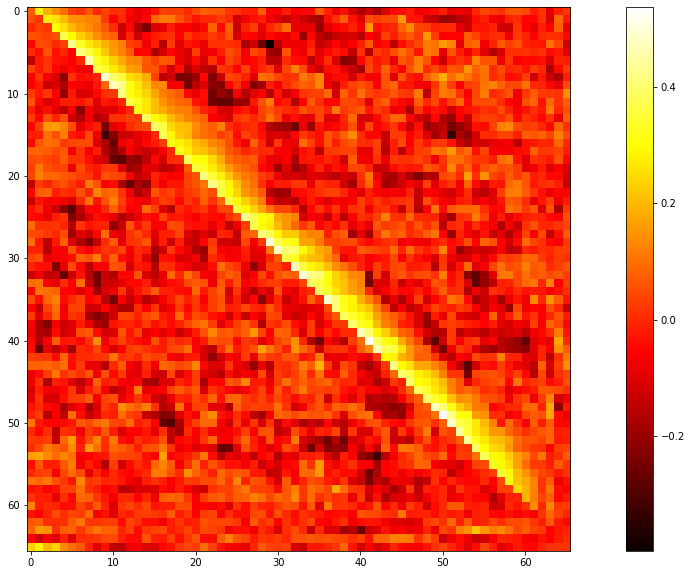

In [ ]:
attn = model.blocks[0].attn
all_token_embeddings = model.embed(range(D_VOCAB))

embeddings_key = einsum("d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head", 
                        all_token_embeddings, attn.W_K) 
embeddings_query = einsum("d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head", 
                          all_token_embeddings, attn.W_Q) 
                          
plt.rcParams['figure.figsize'] = [20, 10]
qk_circuit_attn_heatmap = einsum(
    "n_heads d_vocab_q d_head, n_heads d_vocab_k d_head -> ... d_vocab_q d_vocab_k", 
    embeddings_query, embeddings_key
    ).detach().cpu().numpy()
fig, ax = plt.subplots(figsize=(8, 8))
graph = ax.imshow(qk_circuit_attn_heatmap, cmap="hot", interpolation="nearest")
plt.colorbar(graph)
plt.tight_layout()

In [ ]:
mean_diag = qk_circuit_attn_heatmap.diagonal().mean()
mean_absolute_diag = np.absolute(qk_circuit_attn_heatmap.diagonal()).mean()
print("Mean value on the diagonal: ", mean_diag)
print("Mean absolute value on the diagonal: ", mean_absolute_diag)

Mean value on the diagonal:  0.03559167
Mean absolute value on the diagonal:  0.045249794
